# Ciclope truss FE test
from CT image to beam-FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 12.08.2022 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- For more info on the dataset see [Calculix homepage](http://projects.kmi.open.ac.uk/lhdl/)

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes, plot_projections
import ciclope

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

astropy module not found
olefile module not found


#### Load input data

In [3]:
# input_file = './../../test_data/LHDL/3155_D_4_bc/Tiny_crop/cropped-0000.tif'
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [4]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

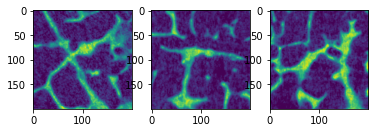

In [7]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [21]:
import itk
from itkwidgets import view

In [ ]:
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

## Pre-processing
### Gaussian smooth

In [5]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [6]:
resampling = 1.0

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

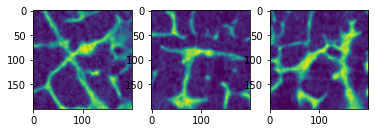

In [9]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding


In [9]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.92566349845595


In [ ]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply the threshold

In [6]:
# BW = data_3D > T
BW = data_3D > 63 # 52?? from comparison with histology

Have a look at the binarized dataset

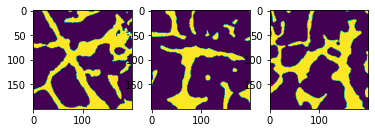

In [11]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [7]:
BW = morphology.closing(BW, morphology.ball(3))

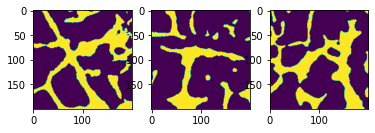

In [15]:
plot_midplanes(BW)
plt.show()

### Detect largest isolated cluster of voxels

In [8]:
from ciclope.utils.preprocess import remove_unconnected

In [9]:
BW = remove_unconnected(BW)

---
## Skeletonization with `skimage.skeletonize_3d`
https://github.com/seung-lab/cloud-volume/wiki/Advanced-Topic:-Skeletons

In [10]:
from skimage.morphology import skeletonize, skeletonize_3d,  medial_axis
from skimage.util import invert
from skimage import data

Invert the image

In [11]:
inverseBW = invert(BW)

3D skeletonization with [scikit.skeletonization_3d]()

In [12]:
ske = skeletonize_3d(BW).astype(np.uint8)

Plot max-projs of the skeleton

In [18]:
from ciclope.utils.recon_utils import plot_projections

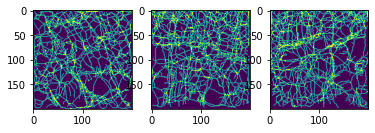

In [19]:
plot_projections(ske)

Display with itkviewer

In [ ]:
# viewer = view(skeletonBW, ui_collapsed=True)
viewer = view(ske, ui_collapsed=True)
viewer.interpolation = False
viewer

Compute the medial axis (skeleton) and the distance transform

In [45]:
# skel, distance = medial_axis(BW, return_distance=True) # not working for 3D images!

---
### Compute graph from the skeleton using the [sknw](https://github.com/Image-Py/sknw) package

In [14]:
import sknw

build graph from skeleton

In [15]:
graph = sknw.build_sknw(ske)

In [16]:
print(graph)

Graph with 935 nodes and 1120 edges


---
### Graph object contents:

- `graph.edges(i)` lists the connectivity of node `i` (i.e. all the arcs of the graph leaving node `i`)
- `graph.nodes[i]` stores the coordinates of all voxels classified as graph node `i`. One graph node can be one or more voxels.
    - `graph.nodes[i]['pts']`: points identified as node `i` 
    - `graph.nodes[i]['o']`: origin of node `i` as average of `pts`
- `graph.degree(i)` reports the degree of connectivity of node `i` (i.e. number of arcs connected to node `i`
- `graph.adj[i][j]` reports the two fields `pts` and `weight` for the arc `i-j`
    - `graph.adj[i][j]['pts']` lists the coordinates of voxels belonging to the arc `i-j`. This is equivalent to the call `graph[i][j]['pts']`

For instance, print the connectivity of node `176`:

In [47]:
graph.edges(176)

EdgeDataView([(176, 5), (176, 149), (176, 197)])

Print the coordinates of all points belonging to the graph arc between nodes `176` and `5`:

In [48]:
graph[176][5]['pts']

array([[ 2, 36, 98],
       [ 3, 36, 98],
       [ 4, 36, 97],
       [ 5, 36, 97],
       [ 6, 36, 97],
       [ 7, 35, 96],
       [ 8, 35, 96],
       [ 9, 36, 96],
       [10, 36, 96],
       [11, 36, 96],
       [12, 36, 96],
       [13, 36, 96],
       [14, 35, 96],
       [14, 34, 96],
       [15, 33, 95],
       [16, 33, 95],
       [17, 32, 95],
       [18, 32, 95],
       [19, 31, 95],
       [20, 31, 95],
       [21, 31, 95],
       [22, 31, 95],
       [23, 30, 96],
       [24, 29, 97],
       [25, 28, 97],
       [26, 28, 97],
       [27, 27, 98],
       [28, 27, 98],
       [29, 26, 99]], dtype=int16)

the coordinates of these nodes are stored in `graph.nodes`

---
#### Plotting the graph

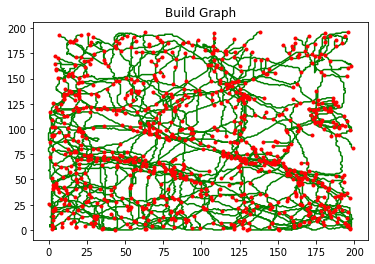

In [27]:
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

---
## Skeletonization with [`kimimaro`](https://pypi.org/project/kimimaro/)

See [Kimimaro Skelton Web](https://github.com/topics/skeletonization)

Skeletonizing Labels: 100%|██████████| 17/17 [00:00<00:00, 27.49it/s]


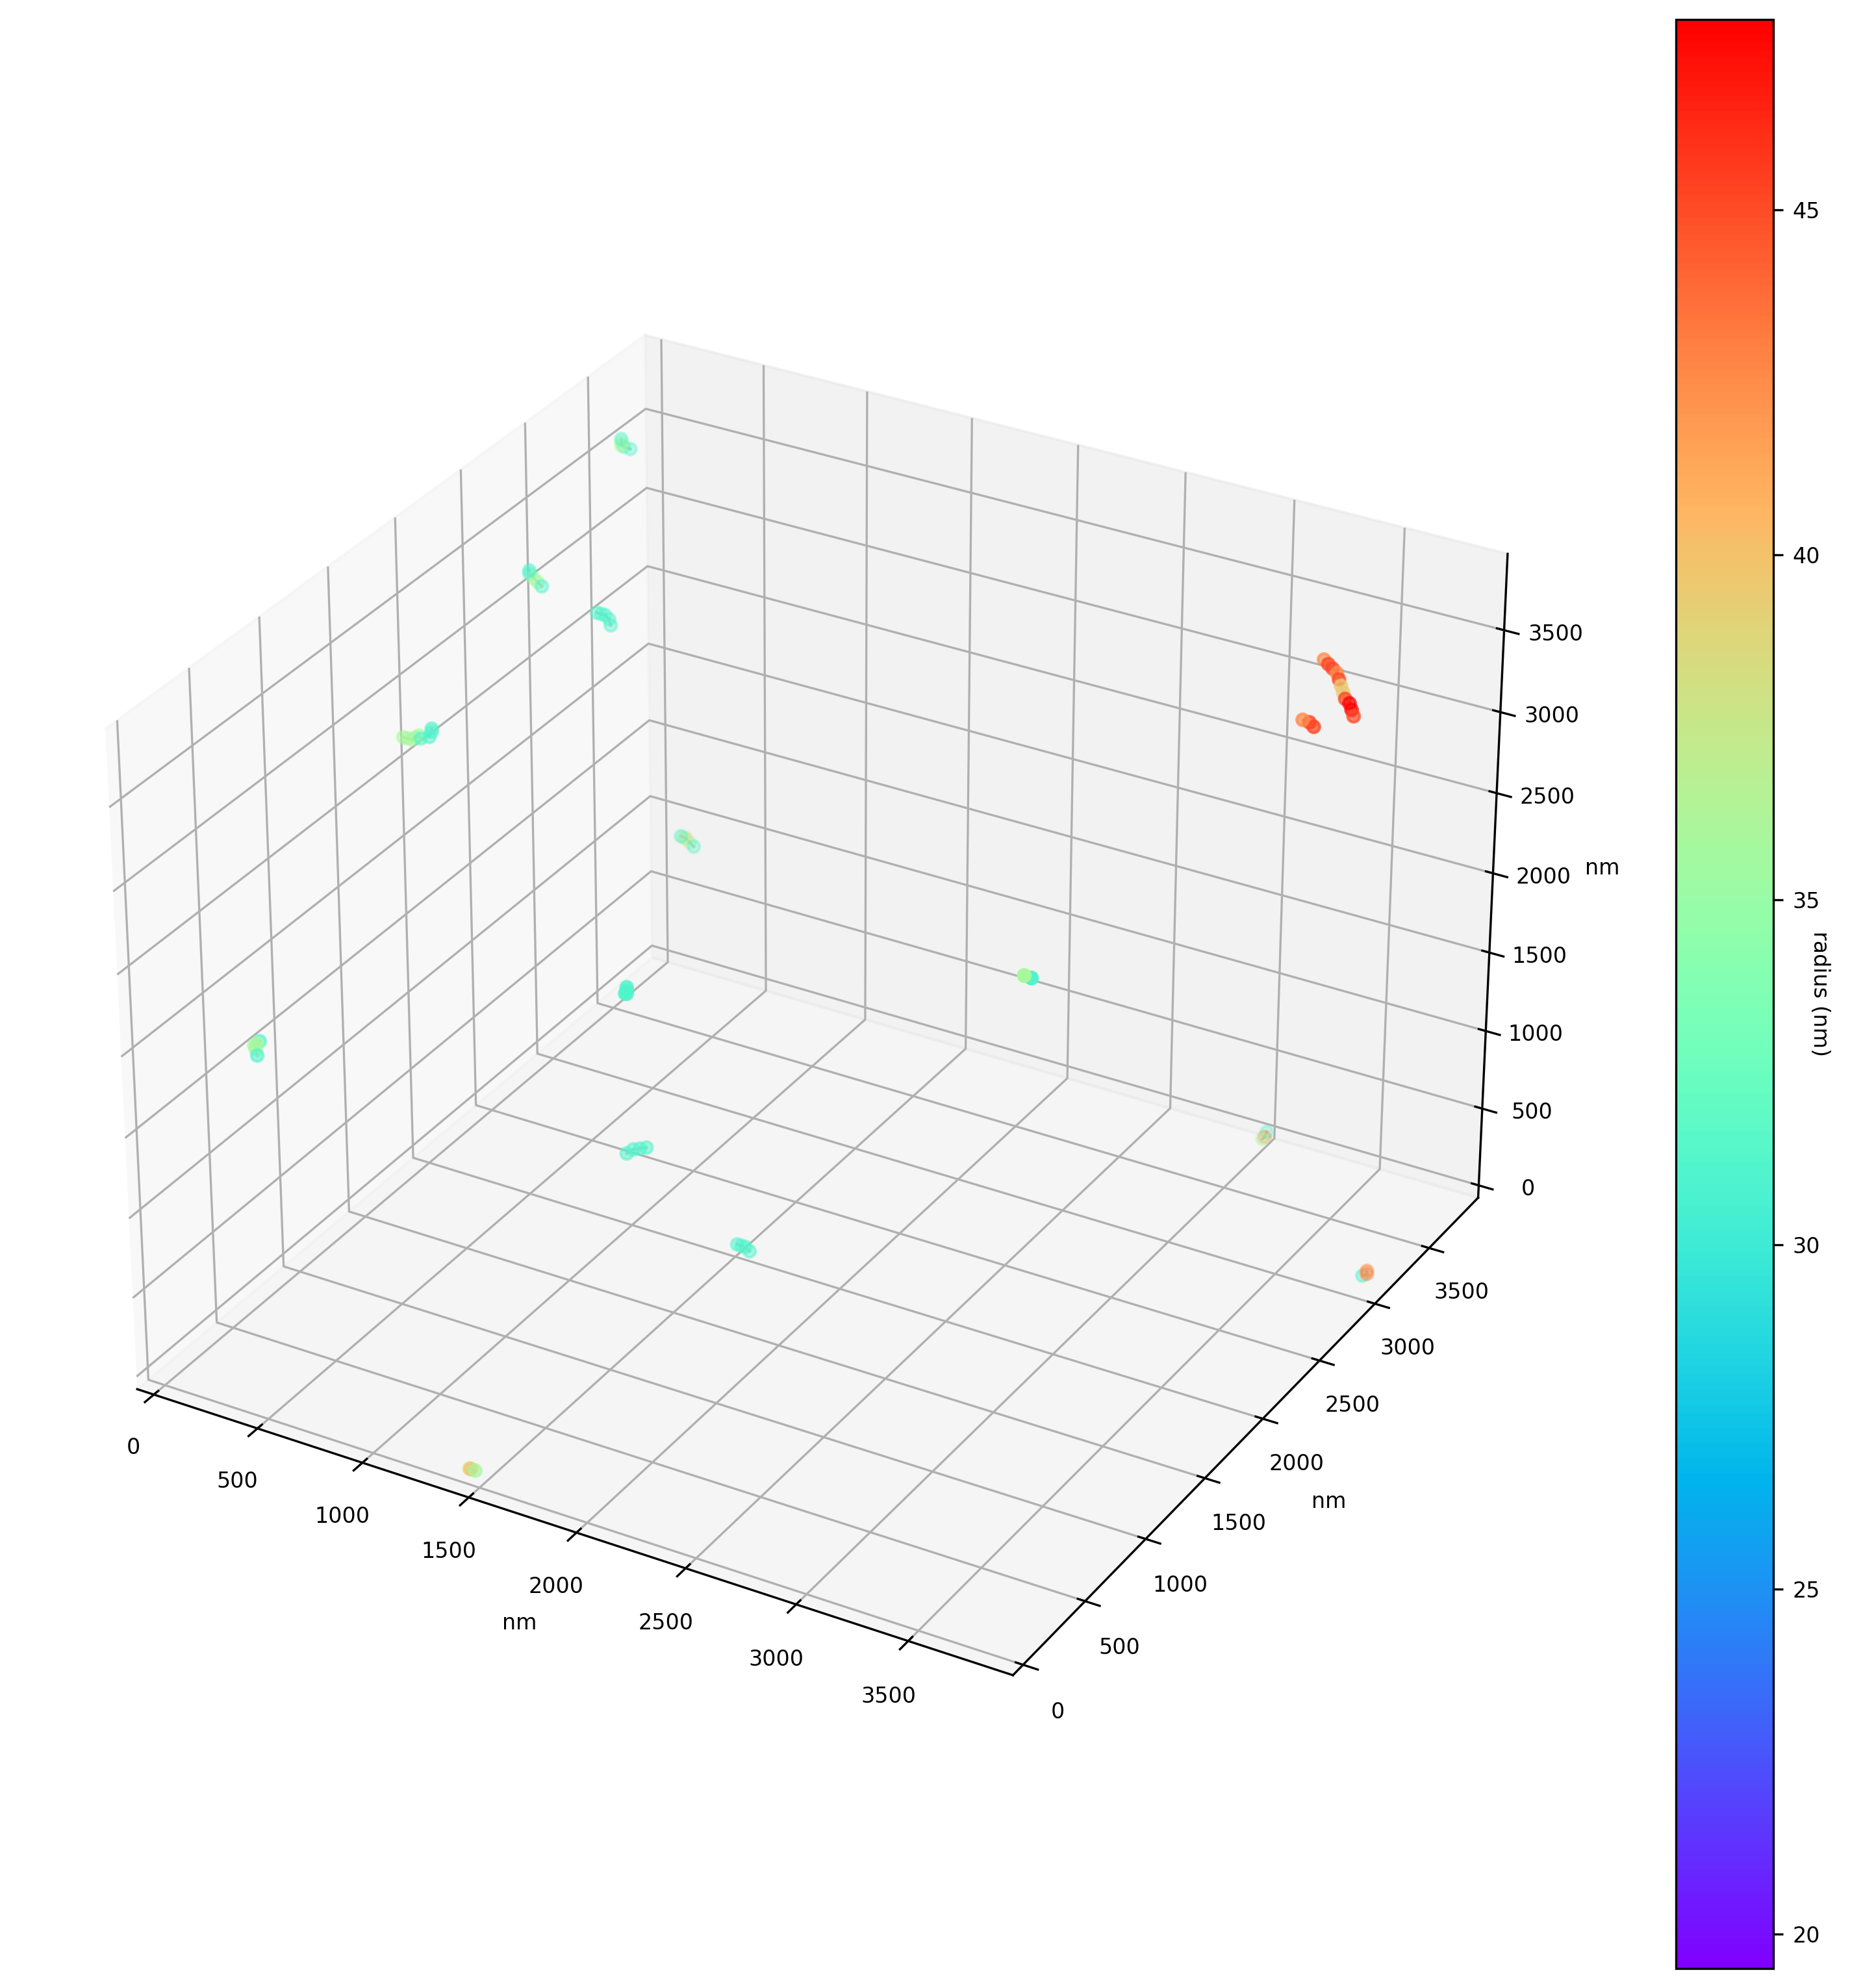

In [198]:
import kimimaro
# https://github.com/seung-lab/kimimaro
#
# Run lzma -d connectomics.npy.lzma on the command line to 
# obtain this 512 MB segmentation volume. Details below.

skels = kimimaro.skeletonize(
  BW, 
  teasar_params={
    'scale': 3.5, #(small values for small branches)
    'const': 0, # physical units
    'pdrf_exponent': 16,
    'pdrf_scale': 100000,#100000,
    'soma_detection_threshold': 400*19.5,#1100, # physical units
    'soma_acceptance_threshold': 450*19.5,#3500, # physical units
    'soma_invalidation_scale': 1.0,
    'soma_invalidation_const': 1e-3, # physical units
    'max_paths': 50, # default None
  },
  # object_ids=[ ... ], # process only the specified labels
  # extra_targets_before=[ (27,33,100), (44,45,46) ], # target points in voxels
  # extra_targets_after=[ (27,33,100), (44,45,46) ], # target points in voxels
  dust_threshold=10, # skip connected components with fewer than this many voxels
  anisotropy=(19.50,19.50,19.50), # default True
  fix_branching=True, # default True
  fix_borders=True, # default True
  fill_holes=False, # default False
  fix_avocados=False, # default False
  progress=True, # default False, show progress bar
  parallel=1, # <= 0 all cpu, 1 single process, 2+ multiprocess
  parallel_chunk_size=100, # how many skeletons to process before updating progress bar
)


skels[1].viewer() #

In [194]:
skels

{1: Skeleton(segid=1, vertices=(shape=71, float32), edges=(shape=55, uint32), radius=(71, float32), vertex_types=(71, uint8), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])}

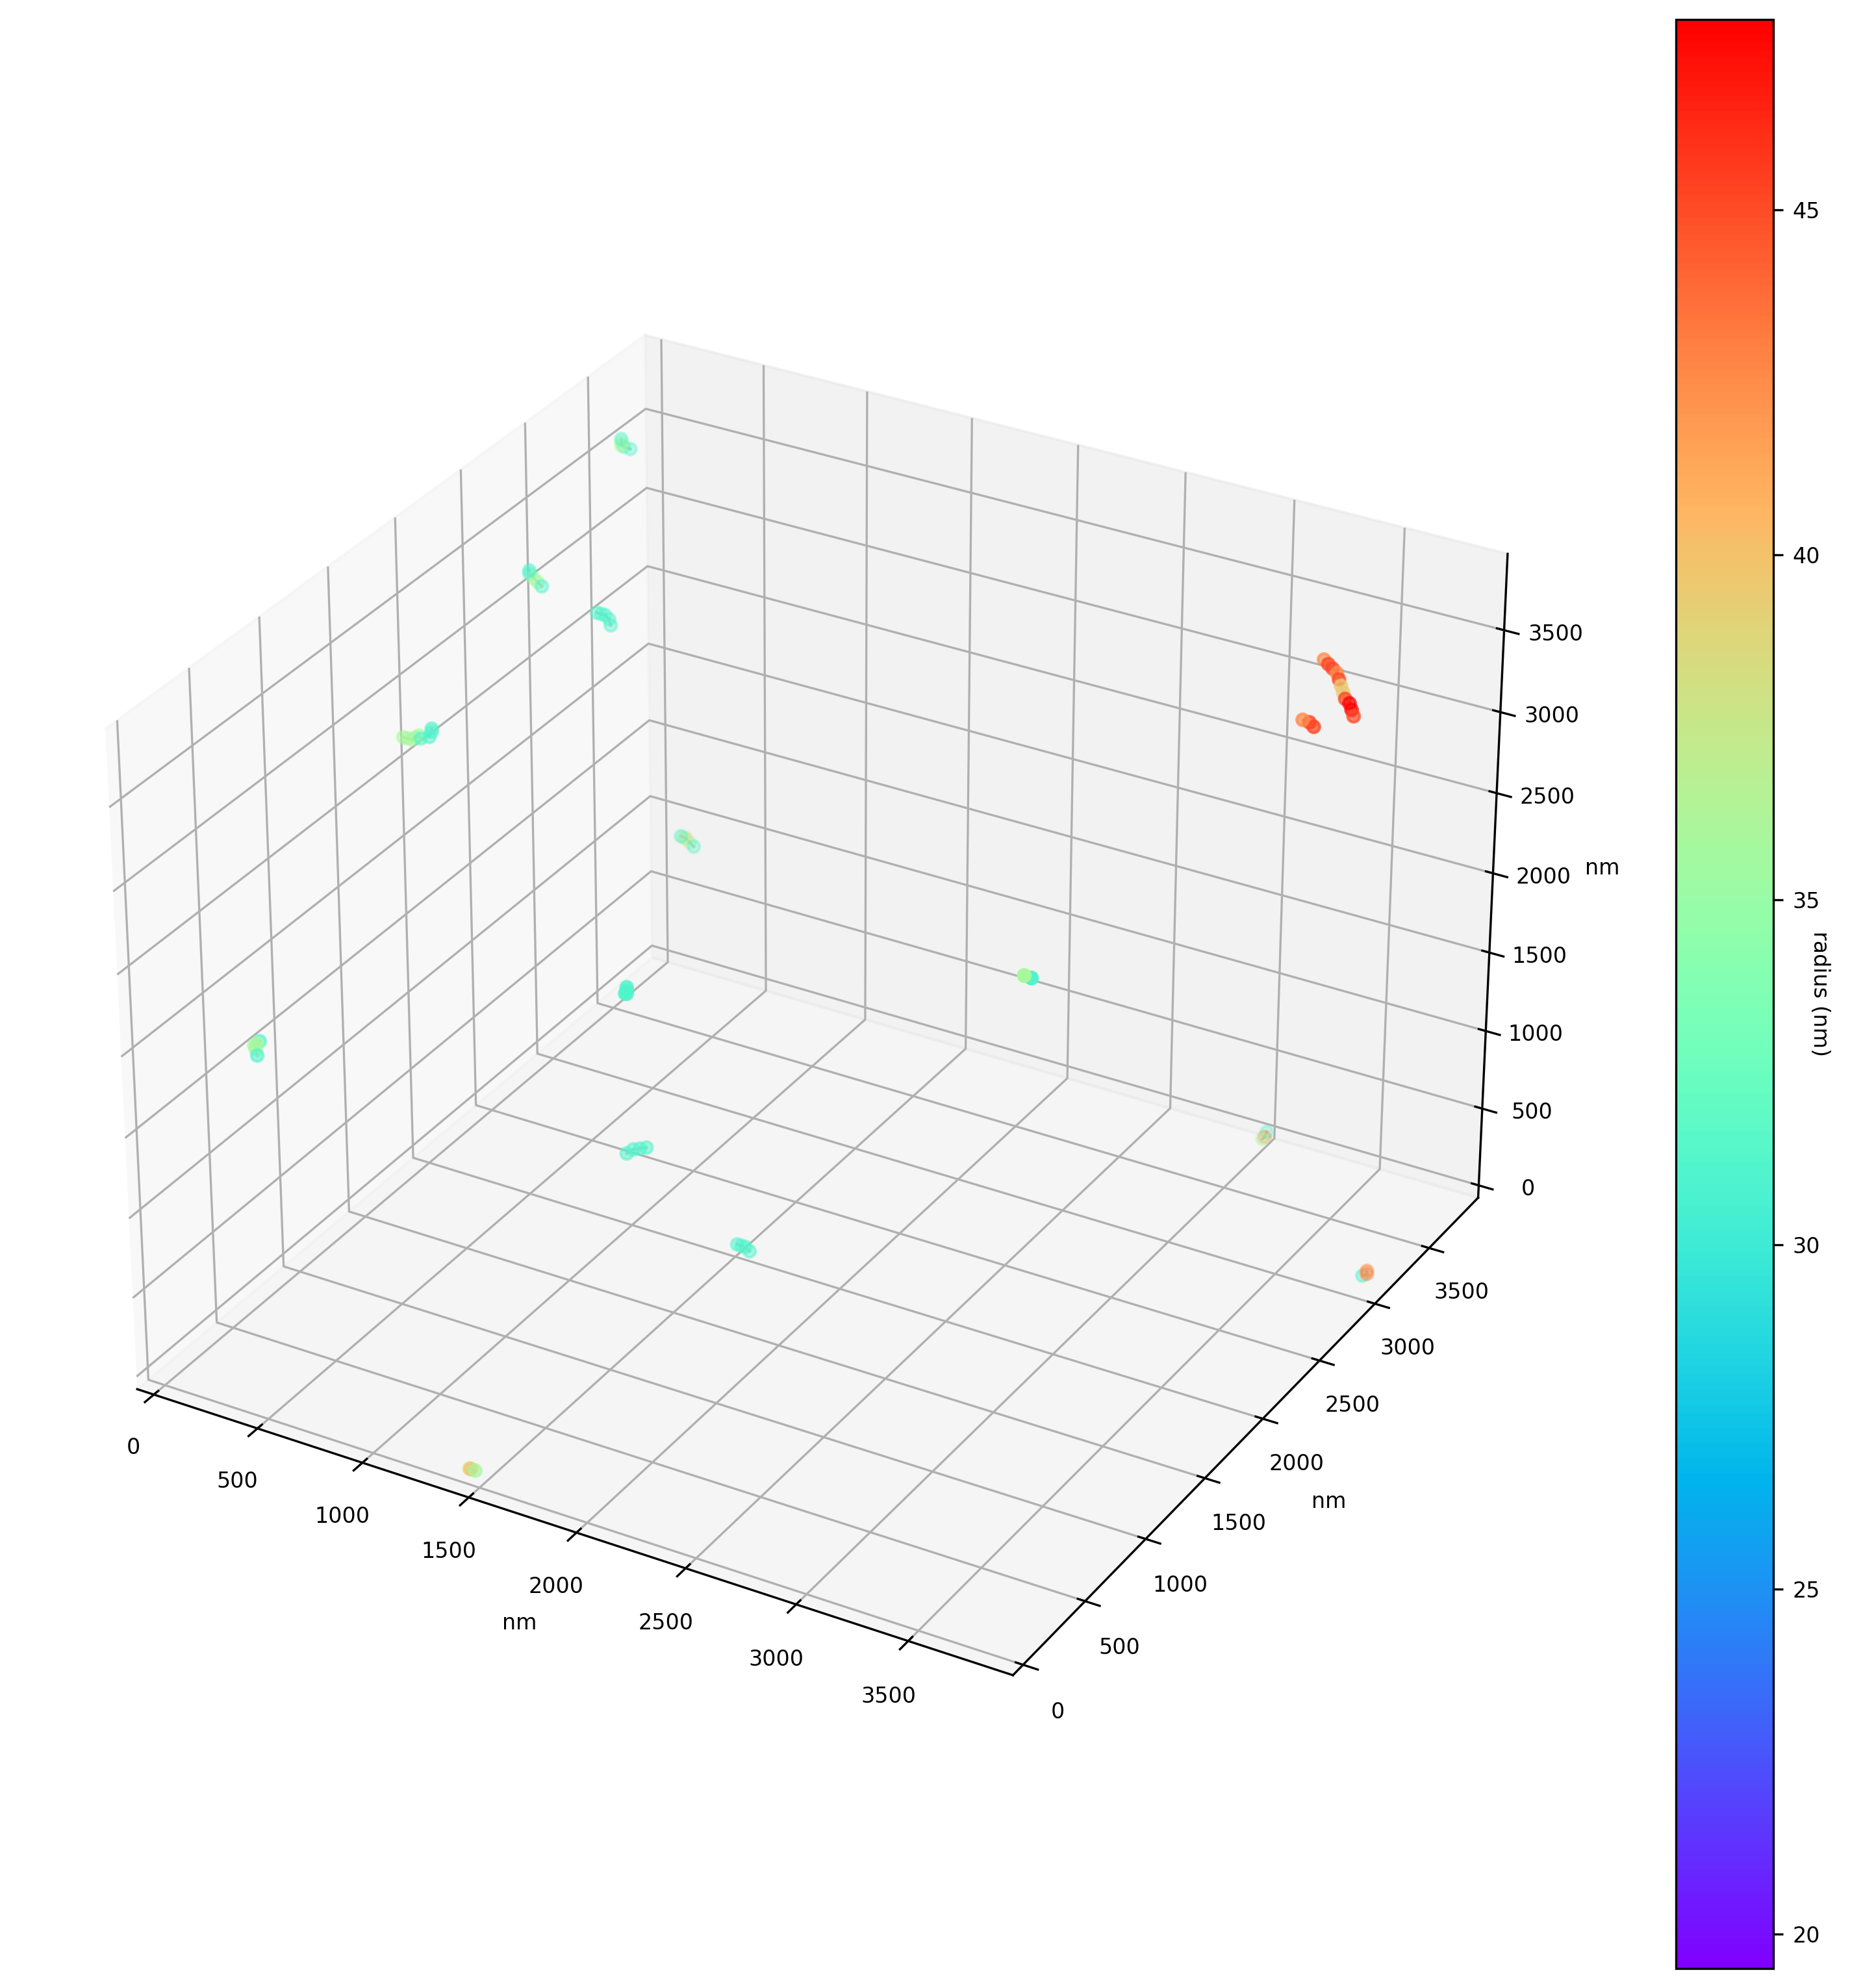

In [199]:
import matplotlib
skels[1].viewer() #

#### Build graph from skeleton

In [ ]:
graph = sknw.build_sknw(skels)

---
## Trabecular local thickness

The local diameter of single trabeculae can be measured by combining the skeleton and the distance transform to the background [Gouillart_2017](https://hal.archives-ouvertes.fr/hal-01448271).

- Gouillart, Emmanuelle, Juan Nunez-Iglesias, and Stéfan van Der Walt. 2017. “Analyzing Microtomography Data with Python and the Scikit-Image Library.” Advanced Structural and Chemical Imaging 2: 18. https://doi.org/10.1186/s40679-016-0031-0.

---
> ## **Update: ITK has an [ITKThickness3D](https://github.com/T4mmi/ITKThickness3D) Python module for both skeleonization and local thickness tested for trabecular bone. Consider to move to this module!!**
> - **Binary thinning** provides a 1 pixel-thin wire skeleton using an efficient curve thinning algorithm. The thinning algorithm used in this module comes from the Insight Journal article:
    - Homann H., Implementation of a 3D thinning algorithm. The Insight Journal - 2007 July - December. http://hdl.handle.net/1926/1292; http://insight-journal.org/browse/publication/181
> - **Medial thickness** computes twice the shortest distance to the outter shell along the medial axis of the object (i.e. diameter of the local maximal fitting sphere).

### Distance transform from the image background

In [31]:
dist = ndimage.distance_transform_edt(BW)

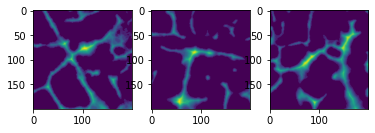

In [32]:
plot_midplanes(dist)

### Mask the distance transform with skeleton image
Convert the skeleton to a mask

In [43]:
ske01 = ciclope.utils.recon_utils.to01(ske).astype(bool)

Masking operation

In [53]:
masked = dist.copy().astype('uint8')

In [54]:
masked[~ske01] = 0

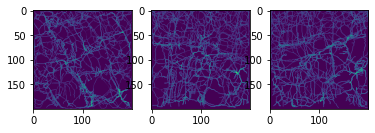

In [55]:
plot_projections(masked)

Write skeleton image as stack of TIFFs for inspection

In [51]:
import dxchange

In [56]:
dxchange.write_tiff_stack(masked, "/home/gianthk/PycharmProjects/CT2FE/test_data/LHDL/3155_D_4_bc/results/skeleton/slice.tiff")

Visualize in ParaView

![skeleton](./../../test_data/LHDL/3155_D_4_bc/results/skeleton.png)

---
### [Skeletor](https://pypi.org/project/skeletor/) turns meshes into skeletons

In [243]:
#pip3 install skeletor
import skeletor as sk
mesh = sk.example_mesh()
fixed = sk.pre.fix_mesh(mesh, remove_disconnected=5, inplace=False)
skel = sk.skeletonize.by_wavefront(fixed, waves=1, step_size=1)
#skel = skeletor.skeletonize.by_teasar()
#Skeleton(BW, mesh=mesn, mesh_map=None, method=None)

Skeletonizing:   0%|          | 0/6213 [00:00<?, ?it/s]